In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# state 정의
class State(TypedDict):
    # 사용자 - 상담사 간의 대화 메세지
    messages: Annotated[list, add_messages]

### 상담사 역할 정의

In [ ]:
from typing import List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser

# 모델 이름 설정
MODEL_NAME = "gpt-4o-mini"


def call_chatbot(messages: List[BaseMessage]) -> dict:
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})

In [7]:
call_chatbot([("user", "안녕하세요")])

'안녕하세요! 어떻게 도와드릴까요?'

### 고객 역할 정의

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


def create_scenario(name: str, instructions: str):
    # 시스템 프롬프트 정의
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean."""

    # 대화 메세지와 시스템 프롬프트를 결험하여 채팅 프롬프트 템플릿 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # 특정 사용자 이름과 지시사항을 사용하여 프롬프트를 부분적으로 채움
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

고객의 입장에서의 가상 시나리오 생성

환불을 요청하는 시나리오 정의

In [9]:
# 사용자 지시사항 정의
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

# 사용자 이름 정의
name = "Jay"

create_scenario(name, instructions).pretty_print()

================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support person. 
Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


In [10]:
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)

simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

In [11]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="안녕하세요? 어떻게 도와드릴까요?")]
simulated_user.invoke({"messages": messages})

'안녕하세요. 저는 작년에 제주도로 여행을 갔었는데, 그 여행에 대한 전액 환불을 요청하고 싶습니다. 도와주실 수 있나요?'

### 노드 정의

In [ ]:
from langchain_core.messages import AIMessage


# 상담사 역할
def ai_assistant_node(messages):
    # 상담사 응답 호출
    ai_response = call_chatbot(messages)

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}

In [13]:
# 상담사 역할 노드 호출
ai_assistant_node(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요. 어떻게 도와드릴까요?"),
        ("user", "제주도 여행에 대한 환불을 받고 싶어요."),
    ]
)

{'messages': [('assistant',
   '환불을 원하시는 제주도 여행의 예약 번호와 함께 어떤 사유로 환불을 요청하시는지 알려주시면, 더 자세히 도와드릴 수 있습니다. 추가로 예약하신 항공편의 날짜와 승객 이름도 함께 말씀해 주시면 감사하겠습니다.')]}

시뮬레이션된 사용자를 위한 노드를 정의
- 메세지의 역할을 교체하는 작은 로직 포함

In [ ]:
def _swap_roles(messages):
    # 메세지의 역할을 교환: 시뮬레이션 사용자 단계에서 메세지 타입을 교환
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages


# 상담사 역할(AI Assistant) 노드 정의
def ai_assistant_node(state: State):
    # 상담사 응답 호출
    ai_response = call_chatbot(state["messages"])
    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}


# 시뮬레이션된 사용자(Simulated User) 노드 정의
def simulated_user_node(state: State):
    # 메세지 타입 교환
    new_messages = _swap_roles(state["messages"])
    # 시뮬레이션된 사용자 호출
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}

### 엣지 정의

두 가지 결과중 하나로 이어져야 함
- 고객 지원 봇을 호출하여 계속 진행(continue)
- 대화를 마치고 종료(end)

In [15]:
def should_continue(state: State):
    # 메세지 리스트의 길이가 6보다 크면 'end'를 반환
    if len(state["messages"]) > 6:
        return "end"
    # 마지막 메세지의 내용이 'FINISHED'라면 'end'를 반환
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # 위 두 조건에 해당하지 않으면 'continue'를 반환
    else:
        return "continue"

### 그래프 정의

In [16]:
from langgraph.graph import END, StateGraph

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의(챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,
        "continue": "ai_assistant",
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()

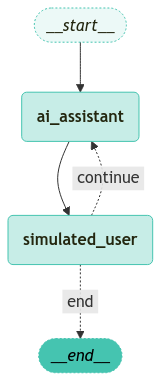

In [17]:
from dataclasses import dataclass


@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )


from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

if isinstance(simulation, CompiledStateGraph):
    display(
        Image(
            simulation.get_graph(xray=False).draw_mermaid_png(
                background_color="white",
                node_colors=NodeStyles(),
            )
        )
    )

In [ ]:
from langchain_core.runnables import RunnableConfig
import os

os.chdir("..")
from tools.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메세지 설정
inputs = {"messages": [HumanMessage(content="안녕하세요? 저 지금 화가 많이 났습니다.")]}

# 그래프 스트리밍
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])


🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 불편을 드려서 정말 죄송합니다. 어떤 문제로 화가 나셨는지 말씀해 주시면, 최대한 도움을 드리도록 하겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년 제주도 여행에 대한 환불을 받고 싶습니다. 모든 금액을 환불받고 싶어요. 어떻게 진행할 수 있나요?
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제주도 여행에 대한 환불 요청을 도와드리겠습니다. 환불 절차는 다음과 같습니다:

1. **예약 확인**: 예약하신 항공편의 예약 번호와 함께 확인해 주세요.
2. **환불 사유**: 환불을 요청하시는 이유를 알려주시면 도움이 됩니다.
3. **고객센터 연락**: 저희 고객센터에 직접 연락 주시거나, 저희 웹사이트의 환불 요청 양식을 작성해 주시면 됩니다.

환불 정책에 따라 처리 기간이 다를 수 있으며, 일부 수수료가 발생할 수 있습니다. 더 자세한 안내가 필요하시다면 고객센터에 문의해 주시면 친절히 안내해 드리겠습니다. 감사합니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호는 123456입니다. 환불 이유는 여행이 취소되었기 때문입니다. 모든 금액을 환불받고 싶습니다. 수수료 없이 환불 가능한가요?
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호 123456으로 확인해 보겠습니다. 여행이 취소된 경우, 환불 정책에 따라 다르게 적용될 수 있습니다. 일반적으로 항공권의 종류나 예약 조건에 따라 수수료가 발생할 수 있습니다.

환불 요청이 수수료